# Preliminaries

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [3]:
THIS = 'dissipation-theory--Study-48--'
figs = {}

In [4]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import Csphere, CsphereOverSemi
from dissipationtheory.dissipation8a import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation8b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation8b import integrand1jit, integrand2jit, K_jit

# New code for `twodimCobject`

Create a metallic sample to work with.  

Actually create a few different metallic samples, each with a different value of the scaling parameter $z_{\mathrm{r}}$.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

sample1_metal = {}
sample1_jit_metal = {}
zr_list = [0.1, 1, 10, 100]

for zr in zr_list:

    key = 'zr = {:0.1f} nm'.format(zr)
    
    sample1_metal[key] = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(1e-6, 'nm'),  # not zero
        epsilon_s = ureg.Quantity(complex(1, 0), ''),
        sigma = ureg.Quantity(1e9, 'S/m'),
        rho = ureg.Quantity(1e26, '1/m^3'),
        epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
        z_r = ureg.Quantity(zr, 'nm') # <== vary this
    )
    
    sample1_jit_metal[key] = SampleModel1Jit(**sample1_metal[key].args())

In [6]:
sample1_jit_metal.keys()

dict_keys(['zr = 0.1 nm', 'zr = 1.0 nm', 'zr = 10.0 nm', 'zr = 100.0 nm'])

In [7]:
sample1_jit_metal['zr = 0.1 nm'].z_r

1.0000000000000002e-10

Now create the new `twodimCobject`.

In [8]:
class twodimCobject():

    def __init__(self, sample, integrand):
        """Here sample is a SampleModel1Jit or SampleModel2Jit object
        and integrand is integrand1jit or integrand2jit."""

        self.sample = sample
        self.integrand = integrand

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(sample.z_r, 'm')
        
        self.cG = (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
        self.cGinv = 1/self.cG

    def addsphere(self, r, h, N, M):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: 
        (a) self.rk, the voltage-test points, and (b) self.rj, the image-charge
        points, with the coordinates in nanometers.
        """

        # convert to nm and strip units
        r = r.to('nm').magnitude
        h = h.to('nm').magnitude
        
        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rj = np.array([[0, 0, h + r + r * delta] for delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=M)
        self.rk = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 'r': r, 'h': h, 'N': N, 'M': M }
        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}

    def plot(self, N=0, M=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if N == 0:
            N = self.info['N']

        if M == 0:
            M = self.info['M']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rj[0:N,0], self.rj[0:N,2], 
            marker='.', c=self.results['q'][0:N], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:N])), 
            vmax=max(abs(self.results['q'][0:N])))
        ax1.scatter(self.rk[0:M,0], self.rk[0:M,2], marker='.')
        ax1.set_xlabel('$x$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rj[0:N,2], self.results['q'][0:N], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)

        V = self.results['V'][0:M]
        ax3.plot(1e6 * (V - np.ones_like(V)), '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$\delta V/V_0$ [ppm]')
        
        ax4.plot(self.results['S'][0:N], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:N], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig

    def _Kcoulomb(self, location1, location2):
        """Returns the *normalized* Coulomb potential Greens function. 
        Here location1 and location2 is each a unitless vector of components 
        representing distances in in nanometers."""

        r1 = (ureg.Quantity(location1, 'nm') / self.zr).to('').magnitude
        r2 = (ureg.Quantity(location2, 'nm') / self.zr).to('').magnitude
        
        return complex(1,0) / np.linalg.norm(r1 - r2)
    
    def _Ksample(self, n, omega, location1, location2):
        """Returns the *normalized* 
        :math:'z_{\mathrm{r}}^{n+1} K_{n}(\omega, \vect{r}_1, \vect{r}_2)' with $n$
        an integer, omega a freqency, and :mathrm:'\vect{r}_1' and mathrm:'\vect{r}_1'
        to location vectors. Since we are feeding inputs into `K_jit`, the inputs should 
        be floating point numbers.  Here omega represents a frequency in hertz, and 
        location1 and location2 is each a unitless vector of components representing
        distances in in nanometers."""
        
        Kr = self.zr**(n+1) * \
            K_jit(integrand=self.integrand,
                power=n,
                sample=self.sample, 
                omega=omega,
                location1=location1 * 1e-9,
                location2=location2 * 1e-9,
                isImag=False)

        Ki = self.zr**(n+1) * \
            K_jit(integrand=self.integrand, 
                power=n,
                sample=self.sample, 
                omega=omega,
                location1=location1 * 1e-9,
                location2=location2 * 1e-9,
                isImag=True)
        
        return (complex(1,0) * Kr + complex(0,1) * Ki).to('').magnitude

    def solve(self, omega, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.         
        """

        Kcoulomb = np.array([[self._Kcoulomb(rj,rk) for rj in self.rj] for rk in self.rk])
        K0 = np.array([[self._Ksample(0, omega, rj, rk) for rj in self.rj] for rk in self.rk])
        
        G0 = Kcoulomb - K0
        
        U, S, VT = np.linalg.svd(G0, full_matrices=False)
        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        self.results['S'] = S                      # unitless
        self.results['Sinv'] = np.diagonal(Sinv)   # unitless
        self.results['cn'] = S.max()/S.min()       # unitless
        
        IdN = np.ones(self.info['N']).T
        IdM = np.ones(self.info['M'])

        Q = self.cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * self.cG * G0 @ Q

        self.results['q'] = np.imag(Q) # units of qe 
        self.results['V'] = np.real(V) # units of Vr
        
        K1 = np.array([[self._Ksample(1, omega, rj, rk)  for rj in self.rj] for rk in self.rk]) 
        K2 = np.array([[self._Ksample(2, omega, rj, rk)  for rj in self.rj] for rk in self.rk]) 
        
        L0 = IdN @ G0inv @ IdM
        L1 = -2 * IdN @ G0inv @ K1 @ G0inv @ IdM
        L2 = 4 * IdN @ (G0inv @ K2 @ G0inv + 2 * G0inv @ K1 @ G0inv @ K1 @ G0inv) @ IdM

        self.results['L0'] = L0
        self.results['L1'] = L1
        self.results['L2'] = L2
        
        c = self.cGinv * (qe / self.Vr)
        C0 = (c / self.zr**0) * np.imag(complex(0,1) * L0) 
        C1 = (c / self.zr**1) * np.imag(complex(0,1) * L1) 
        C2 = (c / self.zr**2) * np.imag(complex(0,1) * L2)
        
        for key, values, unit in zip(
            ['C0 [aF]', 'C1 [pF/m]', 'C2 [mF/m^2]'],
            [C0, C1, C2],
            ['aF', 'pF/m', 'mF/m^2']):

            self.results[key] = values.to(unit).magnitude

In [9]:
obj = {}
obj['A'] = twodimCobject(sample1_jit_metal['zr = 100.0 nm'], integrand1jit)

params = {'r': ureg.Quantity(30.0, 'nm'),
          'h': ureg.Quantity(15.0, 'nm'),
          'N': 15, # image charges
          'M': 30} # test points

obj['A'].addsphere(**params)

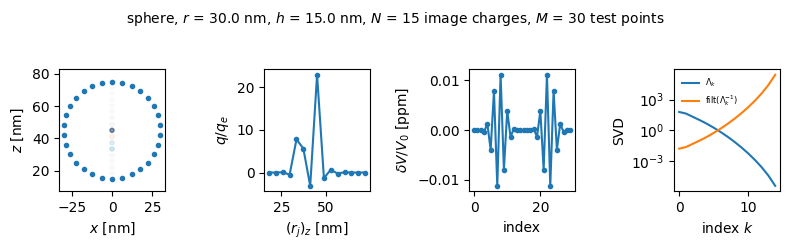

In [10]:
obj['A'].solve(0.)
figs['01'] = obj['A'].plot()

Compare the computed capacitances to ones calculated from analytical series expansions.

In [11]:
results = {key: obj['A'].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
results['h [nm]'] = obj['A'].info['h']
for key, index, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
    newkey = '{:} calc [{:}]'.format(key,unit)
    results[newkey] = Csphere(
        index, 
        ureg.Quantity(np.array([obj['A'].info['h']]), 'nm'), 
        ureg.Quantity(obj['A'].info['r'], 'nm'))[0].to(unit).magnitude

In [12]:
results

{'C0 [aF]': 5.1249842502217335,
 'C1 [pF/m]': -70.72348319340756,
 'C2 [mF/m^2]': 6.233566069839115,
 'h [nm]': 15.0,
 'C0 calc [aF]': 5.124990225209924,
 'C1 calc [pF/m]': -70.72379118457962,
 'C2 calc [mF/m^2]': 6.233576686412819}

# Simulate the capacitances over a metal at various heights

Make a big function to do this.  Here `zrkey` is one of the following keys.

In [13]:
sample1_jit_metal.keys()

dict_keys(['zr = 0.1 nm', 'zr = 1.0 nm', 'zr = 10.0 nm', 'zr = 100.0 nm'])

In [14]:
sample1_jit_metal['zr = 0.1 nm'].epsilon_d.real

1000000.0

Now the function:

In [15]:
def Ctable(sample,samplekey):
    
    obj = {}
    
    r = ureg.Quantity(30.0, 'nm')
    h_array = ureg.Quantity(
        np.logspace(
            start=np.log10(15e-9),
            stop=np.log10(1e-6),
            num=20,
            endpoint=True), 
        'm')
    
    for index, h in enumerate(h_array):
        
        obj[index] = twodimCobject(sample[samplekey], integrand1jit)
    
        params = {'r': r,
                  'h': h,
                  'N': 15, # image charges
                  'M': 30} # test points
        
        obj[index].addsphere(**params)
        obj[index].solve(0.)

        # Copy the computed capacitances over into a new dictionary
        # Add dictionary entries for the capacitances computed from the series solution
        
        results = {key: obj[index].results[key] for key in ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]']}
        results['h [nm]'] = obj[index].info['h']
        for key, order, unit in zip(['C0', 'C1', 'C2'], [0, 1, 2], ['aF', 'pF/m', 'mF/m^2']):
            newkey = '{:} calc [{:}]'.format(key,unit)
            results[newkey] = CsphereOverSemi(
                order, 
                ureg.Quantity(np.array([obj[index].info['h']]), 'nm'), 
                ureg.Quantity(obj[index].info['r'], 'nm'),
                sample[samplekey].epsilon_d.real)[0].to(unit).magnitude

        # Store the results in a pandas dataframe
        
        if (index == 0):
            df = pd.DataFrame.from_dict([results])
        else:
            dfplus = pd.DataFrame.from_dict([results])
            df = pd.concat([df, dfplus], ignore_index=True)     

    # Have the dataframe show 8 decimal places
    # Calculate the error between the computed capacitances
    # and the capacitances computed from the series solution
    
    pd.options.display.float_format = '{:.8f}'.format
    
    for key1, key2, key3 in zip(
        ['err0 [ppm]', 'err1 [ppm]', 'err2 [ppm]'],
        ['C0 [aF]','C1 [pF/m]','C2 [mF/m^2]'],
        ['C0 calc [aF]','C1 calc [pF/m]','C2 calc [mF/m^2]']):
        df[key1] = 1e6 * (df[key2] - df[key3])/df[key3]
    
    df = df[['h [nm]','C0 [aF]','C0 calc [aF]','err0 [ppm]',
             'C1 [pF/m]','C1 calc [pF/m]','err1 [ppm]',
             'C2 [mF/m^2]','C2 calc [mF/m^2]','err2 [ppm]']]
    
    return df

Now carry out computations for the four different reference heights used above.

In [16]:
dfm = {}
dfm['metal zr = 0.1 nm'] = Ctable(sample1_jit_metal, 'zr = 0.1 nm')
dfm['metal zr = 0.1 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,5.12498425,5.12498447,-0.04292234,-70.72348319,-70.72346110,0.31242216,7.23336402,6.23353796,160394.63566365
1,18.71054578,4.89901732,4.89901752,-0.03961178,-52.53733530,-52.53784534,-9.70792990,4.79848969,3.84147837,249125.78523271
2,23.33896823,4.69070597,4.69070607,-0.02108465,-38.61800212,-38.61801932,-0.44540500,3.20213267,2.34571662,365097.82936646
3,29.11232224,4.50075724,4.50075727,-0.00669880,-28.06779149,-28.06779879,-0.25993733,2.10529458,1.41725959,485468.57031378
4,36.31382920,4.32953935,4.32953935,-0.00039507,-20.16085967,-20.16086134,-0.08312474,1.33815606,0.84613365,581494.90584523
5,45.29677092,4.17703244,4.17703243,0.00074407,-14.30843707,-14.30843693,0.00977134,0.80751452,0.49860992,619531.57517723
6,56.50182041,4.04281053,4.04281053,-0.00018922,-10.03445568,-10.03445427,0.14022707,0.45306841,0.28979471,563411.56653657
7,70.47865984,3.92606111,3.92606111,-0.00092405,-6.95650576,-6.95645686,7.02917574,0.23177197,0.16607516,395584.82310120
8,87.91294610,3.82564129,3.82564129,-0.00129541,-4.77022513,-4.77060085,-78.75816124,0.10638918,0.09386338,133447.20364909
9,109.65994686,3.74016146,3.74016146,-0.00116163,-3.23923053,-3.23923056,-0.01043174,0.03994400,0.05235456,-237048.40221256


In [17]:
dfm['metal zr = 1.0 nm'] = Ctable(sample1_jit_metal, 'zr = 1.0 nm')
dfm['metal zr = 1.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,5.12498425,5.12498447,-0.04294953,-70.72348319,-70.72346110,0.31240822,6.23356607,6.23353796,4.50836651
1,18.71054578,4.89901732,4.89901752,-0.03951008,-52.53782444,-52.53784534,-0.39766880,3.84148059,3.84147837,0.57620988
2,23.33896823,4.69070597,4.69070607,-0.02106925,-38.61800212,-38.61801932,-0.44539420,2.34571464,2.34571662,-0.84613060
3,29.11232224,4.50075724,4.50075727,-0.00675534,-28.06779149,-28.06779879,-0.26009175,1.41725833,1.41725959,-0.89223218
4,36.31382920,4.32953935,4.32953935,-0.00037400,-20.16085967,-20.16086134,-0.08305083,0.84613324,0.84613365,-0.49061474
5,45.29677092,4.17703244,4.17703243,0.00070707,-14.30843707,-14.30843693,0.00968063,0.49860986,0.49860992,-0.13858881
6,56.50182041,4.04281053,4.04281053,-0.00014980,-10.03445459,-10.03445427,0.03209077,0.28979462,0.28979471,-0.31740080
7,70.47865984,3.92606111,3.92606111,-0.00091880,-6.95645701,-6.95645686,0.02074434,0.16607597,0.16607516,4.88199524
8,87.91294610,3.82564129,3.82564129,-0.00132022,-4.77060086,-4.77060085,0.00243165,0.09386338,0.09386338,0.04578017
9,109.65994686,3.74016146,3.74016146,-0.00122322,-3.23923053,-3.23923056,-0.01062549,0.05235456,0.05235456,0.01333300


In [18]:
dfm['metal zr = 10.0 nm'] = Ctable(sample1_jit_metal, 'zr = 10.0 nm')
dfm['metal zr = 10.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,5.12498425,5.12498447,-0.04291340,-70.72348320,-70.72346110,0.31244743,6.23356607,6.23353796,4.50874212
1,18.71054578,4.89901732,4.89901752,-0.03958898,-52.53782444,-52.53784534,-0.39775423,3.84148057,3.84147837,0.57221341
2,23.33896823,4.69070597,4.69070607,-0.02104362,-38.61800212,-38.61801932,-0.44536224,2.34571464,2.34571662,-0.84584774
3,29.11232224,4.50075724,4.50075727,-0.00669675,-28.06779149,-28.06779879,-0.25996454,1.41725833,1.41725959,-0.89223236
4,36.31382920,4.32953935,4.32953935,-0.00030932,-20.16085967,-20.16086134,-0.08304281,0.84613324,0.84613365,-0.49060352
5,45.29677092,4.17703244,4.17703243,0.00061146,-14.30843707,-14.30843693,0.00953020,0.49860985,0.49860992,-0.13895712
6,56.50182041,4.04281053,4.04281053,-0.00014400,-10.03445459,-10.03445427,0.03207143,0.28979472,0.28979471,0.03284221
7,70.47865984,3.92606111,3.92606111,-0.00096337,-6.95645701,-6.95645686,0.02070632,0.16607517,0.16607516,0.06904155
8,87.91294610,3.82564129,3.82564129,-0.00125289,-4.77060086,-4.77060085,0.00261998,0.09386338,0.09386338,0.04593746
9,109.65994686,3.74016146,3.74016146,-0.00116320,-3.23923053,-3.23923056,-0.01051234,0.05235456,0.05235456,0.01336837


In [18]:
dfm['metal zr = 100.0 nm'] = Ctable(sample1_jit_metal, 'zr = 100.0 nm')
dfm['metal zr = 100.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,5.12498425,5.12498447,-0.04294338,-70.72348319,-70.72346110,0.31241873,6.23356607,6.23353796,4.50870019
1,18.71054578,4.89901732,4.89901752,-0.03956645,-52.53782444,-52.53784534,-0.39772317,3.84148057,3.84147837,0.57234325
2,23.33896823,4.69070597,4.69070607,-0.02108145,-38.61800212,-38.61801932,-0.44539557,2.34571464,2.34571662,-0.84584856
3,29.11232224,4.50075724,4.50075727,-0.00672998,-28.06779149,-28.06779879,-0.25997064,1.41725833,1.41725959,-0.89216573
4,36.31382920,4.32953935,4.32953935,-0.00038786,-20.16085967,-20.16086134,-0.08309606,0.84613324,0.84613365,-0.49056532
5,45.29677092,4.17703244,4.17703243,0.00065969,-14.30843707,-14.30843693,0.00960591,0.49860985,0.49860992,-0.13875605
6,56.50182041,4.04281053,4.04281053,-0.00010241,-10.03445459,-10.03445427,0.03212726,0.28979472,0.28979471,0.03288005
7,70.47865984,3.92606111,3.92606111,-0.00099775,-6.95645701,-6.95645686,0.02072927,0.16607517,0.16607516,0.06900212
8,87.91294610,3.82564129,3.82564129,-0.00122490,-4.77060086,-4.77060085,0.00263840,0.09386338,0.09386338,0.04597759
9,109.65994686,3.74016146,3.74016146,-0.00121276,-3.23923053,-3.23923056,-0.01048818,0.05235456,0.05235456,0.01339681


# Simulate the capacitances over a dielectric at various heights

Make a semi-infinite dielectric substrate with various $z_{\mathrm{r}}$.  There are two ways to model a semi-infinite dielectric using a Type I sample.  

- Method 1: Make $h_{\mathrm{s}} \ll h$, with $h$ the tip-sample separation; set $\epsilon_{\mathrm{s}} \geq 1$; and make the underlayer essentially metallic.
- Method 2: Make $h_{\mathrm{s}}$ very small (approaching zero) and set the underlayer parameters to model a semiconductor, with $\epsilon_{\mathrm{d}} \geq 1$, $\rho = 0$, and $\sigma$ near zero.

Here we use Method 1.  In the above code we use $\epsilon_{\mathrm{d}}$ to compute the capacitance; so when using Method 1, is it important to set $\epsilon_{\mathrm{d}} = \epsilon_{\mathrm{s}}$, the intended dielectric constant for the semiconductor overlayer (i.e., 3).  

In [29]:
sample1_semi = {}
sample1_jit_semi = {}
zr_list = [0.1, 1, 10, 100]

for zr in zr_list:

    key = 'zr = {:0.1f} nm'.format(zr)
    
    sample1_semi[key] = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(100, 'um'),
        epsilon_s = ureg.Quantity(complex(3, 0), ''),
        sigma = ureg.Quantity(1e-9, 'S/m'),  # not exactly zero
        rho = ureg.Quantity(0., '1/m^3'),
        epsilon_d = ureg.Quantity(complex(3, 0), ''),
        z_r = ureg.Quantity(zr, 'nm') # <== vary this
    )
    
    sample1_jit_semi[key] = SampleModel1Jit(**sample1_semi[key].args())

Now cycle through samples with various $z_{\mathrm{r}}$.

In [30]:
dfs = {}
dfs['diel zr = 0.1 nm'] = Ctable(sample1_jit_semi, 'zr = 0.1 nm')
dfs['diel zr = 0.1 nm']

/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation8b.py:329: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(integrand, 0., np.inf, args=(power, sample, omega, location1, location2, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation8b.py:329: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(integrand, 0., np.inf, args=(power, sample, omega, location1, location2, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation8b.py:329: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(integrand, 0., np.inf, args=(power, sample, omega, location1, location2, False))[0]


,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,4.02314335,4.02314340,-0.01063038,-19.69966654,-19.69966613,0.02086462,1.51740521,1.21262691,251337.24121645
1,18.71054578,3.95748367,3.95748370,-0.00827630,-15.90808837,-15.90815626,-4.26795872,1.17378997,0.85989065,365045.63102149
2,23.33896823,3.89199118,3.89199120,-0.00353924,-12.59548784,-12.59549132,-0.27636539,0.88448231,0.59450566,487760.96561139
3,29.11232224,3.82795163,3.82795163,-0.00001307,-9.77455357,-9.77455510,-0.15636086,0.64211080,0.40043783,603521.84154532
4,36.31382920,3.76657662,3.76657661,0.00160675,-7.43467568,-7.43467594,-0.03483251,0.44312408,0.26265714,687081.77236054
5,45.29677092,3.70891355,3.70891354,0.00159724,-5.54460746,-5.54460728,0.03300107,0.28607689,0.16777297,705142.93302698
6,56.50182041,3.65577497,3.65577496,0.00088381,-4.05744386,-4.05744332,0.13395387,0.16947332,0.10441672,623047.75690799
7,70.47865984,3.60769834,3.60769834,0.00027132,-2.91662766,-2.91669906,-24.47880206,0.08929837,0.06338870,408742.70027106
8,87.91294610,3.56494040,3.56494040,0.00000318,-2.06244075,-2.06252153,-39.16998167,0.04194464,0.03759619,115661.91762944
9,109.65994686,3.52750251,3.52750251,-0.00013671,-1.43698632,-1.43703867,-36.42452002,0.01688746,0.02182885,-226369.76404430


In [31]:
dfs['diel zr = 1.0 nm'] = Ctable(sample1_jit_semi, 'zr = 1.0 nm')
dfs['diel zr = 1.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,4.02314335,4.02314340,-0.01069304,-19.69966654,-19.69966613,0.02079692,1.21262964,1.21262691,2.25202070
1,18.71054578,3.95748367,3.95748370,-0.00834773,-15.90815201,-15.90815626,-0.26741713,0.85988725,0.85989065,-3.94995468
2,23.33896823,3.89199118,3.89199120,-0.00356139,-12.59548784,-12.59549132,-0.27641667,0.59450529,0.59450566,-0.61343751
3,29.11232224,3.82795163,3.82795163,-0.00002805,-9.77455357,-9.77455510,-0.15647956,0.40043756,0.40043783,-0.67312858
4,36.31382920,3.76657662,3.76657661,0.00162858,-7.43467568,-7.43467594,-0.03482785,0.26265704,0.26265714,-0.37968062
5,45.29677092,3.70891355,3.70891354,0.00160032,-5.54460746,-5.54460728,0.03303976,0.16777295,0.16777297,-0.09545945
6,56.50182041,3.65577497,3.65577496,0.00092699,-4.05744352,-4.05744332,0.04946765,0.10441671,0.10441672,-0.13993503
7,70.47865984,3.60769834,3.60769834,0.00038003,-2.91669917,-2.91669906,0.03819736,0.06339037,0.06338870,26.36171272
8,87.91294610,3.56494040,3.56494040,-0.00007841,-2.06252158,-2.06252153,0.01993225,0.03759620,0.03759619,0.06969388
9,109.65994686,3.52750251,3.52750251,-0.00010701,-1.43703868,-1.43703867,0.00570990,0.02182885,0.02182885,0.03606531


In [32]:
dfs['diel zr = 10.0 nm'] = Ctable(sample1_jit_semi, 'zr = 10.0 nm')
dfs['diel zr = 10.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,4.02314335,4.02314340,-0.01066886,-19.69966654,-19.69966613,0.02087104,1.21262964,1.21262691,2.25227009
1,18.71054578,3.95748367,3.95748370,-0.00829739,-15.90815201,-15.90815626,-0.26726578,0.85989091,0.85989065,0.30497647
2,23.33896823,3.89199118,3.89199120,-0.00357413,-12.59548784,-12.59549132,-0.27645553,0.59450529,0.59450566,-0.61333124
3,29.11232224,3.82795163,3.82795163,0.00010677,-9.77455357,-9.77455510,-0.15614600,0.40043756,0.40043783,-0.67274756
4,36.31382920,3.76657662,3.76657661,0.00155836,-7.43467568,-7.43467594,-0.03504455,0.26265704,0.26265714,-0.37992243
5,45.29677092,3.70891355,3.70891354,0.00158299,-5.54460746,-5.54460728,0.03302463,0.16777295,0.16777297,-0.09532118
6,56.50182041,3.65577497,3.65577496,0.00092676,-4.05744352,-4.05744332,0.04936474,0.10441673,0.10441672,0.05421739
7,70.47865984,3.60769834,3.60769834,0.00034384,-2.91669917,-2.91669906,0.03814025,0.06338871,0.06338870,0.08926118
8,87.91294610,3.56494040,3.56494040,0.00004762,-2.06252158,-2.06252153,0.02014447,0.03759620,0.03759619,0.06871405
9,109.65994686,3.52750251,3.52750251,-0.00016246,-1.43703868,-1.43703867,0.00551985,0.02182885,0.02182885,0.03594628


In [33]:
dfs['diel zr = 100.0 nm'] = Ctable(sample1_jit_semi, 'zr = 100.0 nm')
dfs['diel zr = 100.0 nm']

,h [nm],C0 [aF],C0 calc [aF],err0 [ppm],C1 [pF/m],C1 calc [pF/m],err1 [ppm],C2 [mF/m^2],C2 calc [mF/m^2],err2 [ppm]
0,15.00000000,4.02314335,4.02314340,-0.01068776,-19.69966654,-19.69966613,0.02076668,1.21262964,1.21262691,2.25183097
1,18.71054578,3.95748367,3.95748370,-0.00820591,-15.90815201,-15.90815626,-0.26716065,0.85989091,0.85989065,0.30503188
2,23.33896823,3.89199118,3.89199120,-0.00360341,-12.59548784,-12.59549132,-0.27646801,0.59450529,0.59450566,-0.61334765
3,29.11232224,3.82795163,3.82795163,0.00006909,-9.77455357,-9.77455510,-0.15622246,0.40043756,0.40043783,-0.67283653
4,36.31382920,3.76657662,3.76657661,0.00157499,-7.43467568,-7.43467594,-0.03495480,0.26265704,0.26265714,-0.38003911
5,45.29677092,3.70891355,3.70891354,0.00153842,-5.54460746,-5.54460728,0.03292020,0.16777295,0.16777297,-0.09551503
6,56.50182041,3.65577497,3.65577496,0.00093434,-4.05744352,-4.05744332,0.04944282,0.10441673,0.10441672,0.05446740
7,70.47865984,3.60769834,3.60769834,0.00028586,-2.91669917,-2.91669906,0.03808354,0.06338871,0.06338870,0.08915977
8,87.91294610,3.56494040,3.56494040,-0.00005525,-2.06252158,-2.06252153,0.01993577,0.03759620,0.03759619,0.06848405
9,109.65994686,3.52750251,3.52750251,-0.00011564,-1.43703868,-1.43703867,0.00570299,0.02182885,0.02182885,0.03612156


::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-48.ipynb && open dissipation-theory--Study-48.html

:::